# Introducción a los Sistemas de Recomendación 

**Manuel Montoya Gamio** - Data Scientist @ Belcorp

Taller Gratuito Online DMC | 12 de junio 2020

# 0. Librerías

In [1]:
import pandas
import surprise
import numpy
import matplotlib.pyplot as plt
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate, KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
print(f"Pandas version:   {pandas.__version__}")
print(f"Surprise version: {surprise.__version__}")

Pandas version:   1.0.4
Surprise version: 1.1.0


In [3]:
import random
random.seed(123456)

# 1. Dataset

Vamos a usar el dataset Movielens. Descargado de https://grouplens.org/datasets/movielens/100k/

In [4]:
df_ratings = pandas.read_csv("ml-100k/u.data", sep = "\t", header = None, 
                             usecols = [0, 1, 2],names = ["user", "movie", "rating"])
df_ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
df_movie_info = pandas.read_csv("ml-100k/u.item", sep = "|", encoding = "latin1", header = None, 
                                usecols=[0,1], names = ["movie", "movie name"])
df_movie_info.head()

,movie,movie name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
df_data = pandas.merge(df_ratings, df_movie_info, on = "movie", how = "left")
df_data.head()

,user,movie,rating,movie name
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


### Número de registros en el dataset

In [7]:
ratings = len(df_data)
users = df_data['user'].nunique()
movies = df_data['movie'].nunique()

print(f"Number of registers: {ratings}")
print(f"Number of users: {users}")
print(f"Number of movies: {movies}")

Number of registers: 100000
Number of users: 943
Number of movies: 1682


### Porcentaje de registros llenos

In [8]:
total_ratings = users * movies
total_ratings

1586126

In [9]:
sparcity = ratings / total_ratings * 100
print(f"Matrix sparcity: {100 - sparcity}")

Matrix sparcity: 93.69533063577546


### Distribución de ratings

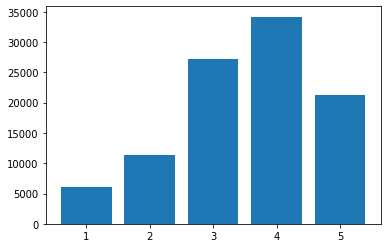

In [10]:
rating_counts = df_data.get(["user", "rating"]).groupby("rating", as_index = False).count()
_ = plt.bar(rating_counts["rating"], rating_counts["user"])

# 1 . Recomendaciones agregadas

## 1.1 Agregación simple de población

Se recomiendan las películas con mayor rating promedio.

In [11]:
#Se obtienen las columnas relevantes y se calcula el promedio de ratings

df_ratings = df_data.get(["movie", "movie name", "rating"])\
                    .groupby(["movie", "movie name"], as_index = False)\
                    .mean()

#Ordenamos los valores de mayor a menor
df_ratings = df_ratings.sort_values(by = "rating", ascending = False)
df_ratings.head(20)

,movie,movie name,rating
813,814,"Great Day in Harlem, A (1994)",5.000000
1598,1599,Someone Else's America (1995),5.000000
1200,1201,Marlene Dietrich: Shadow and Light (1996),5.000000
1121,1122,They Made Me a Criminal (1939),5.000000
1652,1653,Entertaining Angels: The Dorothy Day Story (1996),5.000000
1292,1293,Star Kid (1997),5.000000
1499,1500,Santa with Muscles (1996),5.000000
1188,1189,Prefontaine (1997),5.000000
1535,1536,Aiqing wansui (1994),5.000000
1466,1467,"Saint of Fort Washington, The (1993)",5.000000


Las películas con mayor rating promedio no suenan muy conocidas. Como validación, observamos los registros de estas películas en la tabla de ratings original

In [12]:
df_data.loc[df_data["movie"] == 814]

,user,movie,rating,movie name
6519,13,814,5,"Great Day in Harlem, A (1994)"


In [13]:
df_data.loc[df_data["movie"] == 1599]

,user,movie,rating,movie name
43688,437,1599,5,Someone Else's America (1995)


Los ratings top solo están basados en una review de un usuario. No parece buena idea recomendar según el criterio de una sola persona a toda la población. No es suficiente utilizar solo el promedio de ratings.

## 1.2 Agregación con factor de corrección

Algunos de los registros top de un sistema agregado solo están basados en pocos reviews que no necesariamente son representativos de los usuarios. Para reducir este efecto, la función de agregación debería considerar el número de reviews de la película en el cálculo del rating promedio. 

\begin{align}
rating & = promedio - \frac{C}{\sqrt(numero de reviews)} \\
\end{align}

Con este factor de ajuste, las películas con pocas reviews son penalizadas en mayor medida que las que tienen mayor número de reviews. El valor de C se elige de acuerdo al caso de uso y a la escala de los ratings utilizados.

In [14]:
#Definimos la nueva funcion de agregacion

def promedio_ajustado(ratings):
    rating_promedio = ratings.mean() - 5/numpy.sqrt(ratings.count())
    return rating_promedio

#Calculamos los ratings promedio
df_ratings = df_data.get(["movie", "movie name", "rating"])\
                    .groupby(["movie", "movie name"], as_index = False)\
                    .agg({"rating": promedio_ajustado})

#Ordenamos de mayor a menos los ratings
df_ratings = df_ratings.sort_values(by = "rating", ascending = False)
df_ratings.head(20)

,movie,movie name,rating
317,318,Schindler's List (1993),4.176801
49,50,Star Wars (1977),4.151412
63,64,"Shawshank Redemption, The (1994)",4.148011
482,483,Casablanca (1942),4.136040
11,12,"Usual Suspects, The (1995)",4.079773
602,603,Rear Window (1954),4.041703
126,127,"Godfather, The (1972)",4.037259
97,98,"Silence of the Lambs, The (1991)",4.036559
407,408,"Close Shave, A (1995)",4.018616
173,174,Raiders of the Lost Ark (1981),4.008406


En este caso las películas top son mucho más conocidas y representativas del criterio colectivo de la población

# 2. Factorización de matrices

![SVD](imagenes/svd.png "Title")

Vamos a usar la librería Surprise para el entrenamiento y predicción https://surprise.readthedocs.io/en/stable/matrix_factorization.html

In [15]:
surprise_data = Dataset.load_builtin('ml-100k')

surprise_train = surprise_data.build_full_trainset()
surprise_test = surprise_train.build_anti_testset()

In [16]:
df_surprise_train = pandas.DataFrame(surprise_train.all_ratings(), columns = ["user", "movie", "rating"])
df_surprise_test = pandas.DataFrame(surprise_test, columns = ["user", "movie", "rating"])

In [17]:
len(df_surprise_train), len(df_surprise_test), total_ratings

(100000, 1486126, 1586126)

In [18]:
df_surprise_train.head()

,user,movie,rating
0,0,0,3.0
1,0,528,4.0
2,0,377,4.0
3,0,522,3.0
4,0,431,5.0


In [19]:
df_surprise_test.head()

,user,movie,rating
0,196,302,3.52986
1,196,377,3.52986
2,196,51,3.52986
3,196,346,3.52986
4,196,474,3.52986


In [20]:
svd_model = SVD(n_factors = 100)
svd_model.fit(surprise_train)

In [21]:
item_factors = svd_model.qi
user_factors = svd_model.pu

In [22]:
user_factors.shape, item_factors.shape

((943, 100), (1682, 100))

In [23]:
user_factors

array([[ 0.0266105 ,  0.06025203,  0.08566319, ...,  0.21511733,
        -0.12533402, -0.00043841],
       [ 0.18461436,  0.08313556,  0.11297335, ...,  0.11112745,
         0.08064605, -0.01058021],
       [-0.2329638 , -0.06364168, -0.07143192, ..., -0.33149052,
        -0.09732011, -0.20960678],
       ...,
       [-0.08930141, -0.03784903,  0.0858054 , ...,  0.09872991,
         0.11741055,  0.18086238],
       [ 0.08335138, -0.01023263, -0.06693492, ..., -0.11291521,
        -0.04391528,  0.07073717],
       [-0.00556014, -0.09481054, -0.006733  , ..., -0.08435679,
         0.06510102,  0.1496916 ]])

In [24]:
item_factors

array([[ 0.1241305 , -0.06403889, -0.08358034, ...,  0.03878835,
         0.01747741,  0.02670053],
       [ 0.03788049, -0.28046141,  0.01989553, ..., -0.06631363,
        -0.02681216,  0.07069499],
       [-0.08746864,  0.07432381,  0.03047281, ...,  0.32291951,
         0.10875235, -0.00307026],
       ...,
       [ 0.01183152,  0.01951559, -0.01119704, ..., -0.02755347,
         0.11121069,  0.07183114],
       [-0.04936644, -0.08424419, -0.04998541, ..., -0.13247598,
        -0.02818448,  0.06924553],
       [-0.01609966,  0.16455045, -0.07254858, ...,  0.05972951,
        -0.19666492,  0.04294557]])

# 3. Recomendaciones a usuarios

How to get the top n recommendations for each user: [Surprise Documentation](https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=top%20n#how-to-get-the-top-n-recommendations-for-each-user)

In [25]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [26]:
predictions = svd_model.test(surprise_test)

In [27]:
top_n = get_top_n(predictions, n=10)

df_recomendaciones = pandas.DataFrame(columns = ["user", "movie", "rating"])

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    for (iid, rating) in user_ratings:
        df_recomendaciones.loc[len(df_recomendaciones)] = [int(uid), int(iid), float(rating)]

In [28]:
df_surprise_train = pandas.merge(df_surprise_train, df_movie_info, on = "movie")
df_recomendaciones = pandas.merge(df_recomendaciones, df_movie_info, on = "movie")

df_recomendaciones["user"] = df_recomendaciones["user"].astype("int")
df_recomendaciones["movie"] = df_recomendaciones["movie"].astype("int")

In [29]:
df_surprise_train.head()

,user,movie,rating,movie name
0,0,528,4.0,"Killing Fields, The (1984)"
1,2,528,4.0,"Killing Fields, The (1984)"
2,3,528,3.0,"Killing Fields, The (1984)"
3,5,528,4.0,"Killing Fields, The (1984)"
4,11,528,4.0,"Killing Fields, The (1984)"


In [30]:
df_recomendaciones.head()

,user,movie,rating,movie name
0,196,483,4.670881,Casablanca (1942)
1,186,483,4.420365,Casablanca (1942)
2,22,483,4.748222,Casablanca (1942)
3,244,483,4.804018,Casablanca (1942)
4,166,483,4.586188,Casablanca (1942)


## Visualizando recomendaciones

In [35]:
user = 123

In [39]:
df_surprise_train.loc[df_surprise_train["user"] == user].loc[df_surprise_train["rating"] == 5]

,user,movie,rating,movie name
1505,123,86,5.0,"Remains of the Day, The (1993)"
4166,123,487,5.0,Roman Holiday (1953)
4493,123,512,5.0,Wings of Desire (1987)
5133,123,432,5.0,Fantasia (1940)
5781,123,302,5.0,L.A. Confidential (1997)
17293,123,157,5.0,Platoon (1986)
36642,123,209,5.0,This Is Spinal Tap (1984)
38893,123,408,5.0,"Close Shave, A (1995)"
39879,123,254,5.0,Batman & Robin (1997)
42422,123,103,5.0,All Dogs Go to Heaven 2 (1996)


In [37]:
df_recomendaciones.loc[df_recomendaciones["user"] == user].sort_values(by = "rating", ascending = False)

,user,movie,rating,movie name
2125,123,603,4.585267,Rear Window (1954)
2503,123,169,4.585221,"Wrong Trousers, The (1993)"
6173,123,179,4.458184,"Clockwork Orange, A (1971)"
9113,123,659,4.438923,Arsenic and Old Lace (1944)
5424,123,251,4.429472,Shall We Dance? (1996)
6125,123,488,4.424711,Sunset Blvd. (1950)
6019,123,124,4.413626,Lone Star (1996)
8120,123,474,4.371939,Dr. Strangelove or: How I Learned to Stop Worr...
631,123,408,4.368126,"Close Shave, A (1995)"
6759,123,923,4.361034,Raise the Red Lantern (1991)


## Contacto

**Manuel Montoya Gamio**

* Correo: manuel.montoya@pucp.edu.pe
* Linkedin: https://www.linkedin.com/in/manuel-montoya-gamio/